<a href="https://colab.research.google.com/github/sowmyaannadatha/Content-Based-Image-Retrieval-System---Python/blob/main/Content_based_image_retrieval_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2

import os
print(os.listdir("../input"))

['oregon-wildlife']


In [ ]:
fruit_images = []
labels = []
#for fruit_dir_path in glob.glob("../input/*/fruits-360/Training/*"):
#for fruit_dir_path in glob.glob("../input/*/256_ObjectCategories/*"):
#for fruit_dir_path in glob.glob("../input/*/flowers/*"):
for fruit_dir_path in glob.glob("../input/*/oregon_wildlife/oregon_wildlife/*"):
    fruit_label = fruit_dir_path.split("/")[-1]

    #for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

            #image = cv2.resize(image, (45, 45))
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        fruit_images.append(image)
        labels.append(fruit_label)
fruit_images = np.array(fruit_images)
labels = np.array(labels)

In [ ]:
import math
import numpy as np
from functools import reduce
from collections import defaultdict

_size_data = 0
_dim = 0

def generate_codebook(data, size_codebook, epsilon=0.00005):
    """
    This function will generate the codebook by given the data and the given size. Epsilon is the threshold taht used
    during splitting and looping.
    """
    global _size_data, _dim

    _size_data = len(data)
    assert _size_data > 0

    _dim = len(data[0])
    assert _dim > 0

    codebook = []
    codebook_abs = [_size_data]
    codebook_rel = [1.0]

    # get the initial codevector by taking the average vector of whole input data
    c0 = avg_all_vectors(data, _dim, _size_data)
    codebook.append(c0)

    # initial average distortion
    avg_dist = initial_avg_distortion(c0, data)

    # splitting process until we have exactly same number of codevector with the size of codebook.
    while len(codebook) < size_codebook:
        codebook, codebook_abs, codebook_rel, avg_dist = split_codebook(data, codebook,
                                                                        epsilon, avg_dist)
    #return the result
    return codebook, codebook_abs, codebook_rel

def split_codebook(data, codebook, epsilon, initial_avg_dist):
    """
    Split into 2 codebook the get the best centroid as the new codevector.
    """

    # split into 2
    new_cv = []
    for c in codebook:
        # plus and minus epsilon for the new codebook
        c1 = new_codevector(c, epsilon)
        c2 = new_codevector(c, -epsilon)
        new_cv.extend((c1, c2))

    codebook = new_cv
    len_codebook = len(codebook)
    abs_weights = [0] * len_codebook
    rel_weights = [0.0] * len_codebook

    # Get the best centroid by taking average distortion as cost function. This problems mimic K-Means.
    avg_dist = 0
    err = epsilon + 1
    num_iter = 0
    while err > epsilon:
        # Get nearest codevector.
        closest_c_list = [None] * _size_data    # nearest codevector
        vecs_near_c = defaultdict(list)         # input data vector mapping
        vec_idxs_near_c = defaultdict(list)     # input data index mapping
        for i, vec in enumerate(data):  # for each input vector
            min_dist = None
            closest_c_index = None
            for i_c, c in enumerate(codebook):
                d = get_mse(vec, c)
                # Get the nearest ones.
                if min_dist is None or d < min_dist:
                    min_dist = d
                    closest_c_list[i] = c
                    closest_c_index = i_c
            vecs_near_c[closest_c_index].append(vec)
            vec_idxs_near_c[closest_c_index].append(i)

        # Update the codebook
        for i_c in range(len_codebook):
            vecs = vecs_near_c.get(i_c) or []
            num_vecs_near_c = len(vecs)
            if num_vecs_near_c > 0:
                # assign as new center
                new_c = avg_all_vectors(vecs, _dim)
                codebook[i_c] = new_c
                for i in vec_idxs_near_c[i_c]:
                    closest_c_list[i] = new_c

                # update the weights
                abs_weights[i_c] = num_vecs_near_c
                rel_weights[i_c] = num_vecs_near_c / _size_data

        # Recalculate average distortion
        prev_avg_dist = avg_dist if avg_dist > 0 else initial_avg_dist
        avg_dist = avg_codevector_dist(closest_c_list, data)

        # Recalculate the new error value
        err = (prev_avg_dist - avg_dist) / prev_avg_dist
        num_iter += 1

    return codebook, abs_weights, rel_weights, avg_dist

def avg_all_vectors(vecs, dim=None, size=None):
    """
    This function will get the average of whole data.
    """
    size = size or len(vecs)
    nvec = np.array(vecs)
    nvec = nvec / size
    navg = np.sum(nvec, axis=0)
    return navg.tolist()

def new_codevector(c, e):
    """
    This function will create a new codevector when we split into two.
    """
    nc = np.array(c)
    return (nc * (1.0 + e)).tolist()

def initial_avg_distortion(c0, data, size=None):
    """
    This function will calculate the average distortion of a vector to the input list of vectors.
    """
    size = size or _size_data
    nc = np.array(c0)
    nd = np.array(data)
    f = np.sum(((nc-nd)**2)/size)
    return f

def avg_codevector_dist(c_list, data, size=None):
    """
    This function will calculate the average distortion between list of vector and the input data.
    """
    size = size or _size_data
    nc = np.array(c_list)
    nd = np.array(data)
    f = np.sum(((nc-nd)**2)/size)
    return f

def get_mse(a, b):
    """
    This function will get the squared error, the mean will be calculate later.
    """
    na = np.array(a)
    nb = np.array(b)
    return np.sum((na-nb)**2)
def distance(a, b):
    """
    This function will calculate the distance (MSE) of two vectors.
    """
    return np.mean((np.subtract(a, b) ** 2))


def closest_match(src, cb):
    """
    This function will get the closest distance (nearest) of the compared vectors.
    """
    c = np.zeros((cb.shape[0],))
    for i in range(0, cb.shape[0]):
        c[i] = distance(src, cb[i])
    minimum = np.argmin(c, axis=0)
    return minimum
def encode_image(img, cb, block):
    """
    This function will encode (compress) the image by sending the image block, vectorize it then get the index of the
    closest vector to form the compressed data.
    """
    x = block[0]
    y = block[1]
    compressed = np.zeros((img.shape[0] // y, img.shape[1] // x))
    ix = 0
    for i in range(0, img.shape[0], x):
        iy = 0
        for j in range(0, img.shape[1], y):
            src = img[i:i + x, j:j + y].reshape((x * y)).copy()
            k = closest_match(src, cb)
            compressed[ix, iy] = k
            iy += 1
        ix += 1
    return compressed

In [ ]:
def seg(x):

    x_img1 = []
    x_img2 = []
    x_img3 = []
    x_img4 = []
    r,c = x.shape[0] , x.shape[1]
    k = int (r/2)
    l = int (c/2)
    x_img1 = x[0:k , 0:l]
    x_img2 = x[0:k , l : c]
    x_img3 = x[k : r , 0:l]
    x_img4 = x[k :r , l: c]

    #grads = {"x_img1": x_img1,
            #  "x_img2": x_img2,
            #  "x_img3": x_img3,
             # "x_img4": x_img4}

    return x_img1,x_img2,x_img3,x_img4

In [ ]:
def quad(x1_imge,thres1):
    thres = thres1
    low_detail = []
    high_detail = []

    for l in range(len(x1_imge)):
        k = np.var(x1_imge[l])
        if k < thres:
            low_detail.append(x1_imge[l])

        else:
            high_detail.append(x1_imge[l])
    return low_detail,high_detail

In [ ]:
def down_sample(x):
    y = []
    for l in range(len(x)):
        y.append(np.resize(x[l],(4,4)))
    return y

In [ ]:
def tlocal_impl(G1):
    import numpy as np
    G = np.array(G1)
    tlocal = np.zeros((4,4))
    w = np.zeros((4,4))
    binarized_block = np.zeros((4,4))
    W = 0
    for row in range(4):
        for column in range(4) :
            if row==0 :
                edge_h = abs( G[row + 1,column] - G[row,column])
            elif row==3:
                edge_h = abs(G[row,column] - G[row -1 , column])
            else:
                edge_h = max(abs( G[row + 1,column] - G[row,column]) , abs(G[row,column] - G[row -1 , column]))
            if column==0:
                edge_v = abs(G[row ,column + 1] - G[row , column])
            elif column == 3:
                edge_v = abs(G[row,column] - G[row , column - 1])
            else:
                edge_v = max(abs(G[row ,column + 1] - G[row , column]) , abs(G[row,column] - G[row , column - 1]))
    w[row ,column] = max(edge_h ,edge_v)
    W = W + w[row ,column]
    for row in range(4):
        for column in range(4) :
            tlocal[row ,column] = np.sum((w[row ,column] / W) * G[row ,column])
            if (G[row ,column] > tlocal[row ,column]):
                binarized_block[row ,column] = 1
            else:
                binarized_block[row ,column] = 0
    return binarized_block


In [ ]:
def code_book(img_block,size,epsilon):
    codebook_detail = np.zeros(len(img_block))
    if len(img_block) != 0:
        cb1, cb_abs_w1, cb_rel_w1 = generate_codebook(img_block, size, epsilon)
        cb_abs_w_n = np.array(cb_abs_w1)
        for i in range(len(img_block)):
            codebook_detail[i] = encode_image(img_block[i], cb_abs_w_n, [4,4])
    return codebook_detail

In [ ]:
def QCQV(img,size,template):
    from skimage.transform import resize
    from skimage.color import rgb2gray
    import numpy as np
    img = resize(img,(128,128))
    img = rgb2gray(img)
    thres = np.var(img)
    x_img64 = []
    x_img64 = seg(img)
    x1_img32 = []
    for l in range(4):
        x1_img32 += seg (x_img64[l])
    x1_img16 = []
    for l in range(16):
        x1_img16 += seg (x1_img32[l])


    low_detail1,high_detail1 = quad(x1_img16,thres)
    x1_img8 = []
    for l in range(len(high_detail1)):
        x1_img8 = seg(high_detail1[l])
    low_detail2,high_detail2 = quad(x1_img8,thres)
    x1_img4 = []
    for l in range(len(high_detail2)):
        x1_img4 = seg(high_detail2[l])
    low_detail3,high_detail3 = quad(x1_img4,thres)


    low_de = []
    low_de1 = []
    low_de2 = []
    low_de3 = []
    low_de1.append(np.array(down_sample(low_detail1)))
    low_de2.append(np.array(down_sample(low_detail2)))
    low_de3.append(np.array(low_detail3))
    for l in range(len(low_de1)):
        for x in range(len(low_de1[l])):
            low_de.append(low_de1[l][x])
    for l in range(len(low_de2)):
        for x in range(len(low_de2[l])):
            low_de.append(low_de2[l][x])
    for l in range(len(low_de3)):
        for x in range(len(low_de3[l])):
            low_de.append(np.array(low_de3[l][x]))

    binarized_blocks = []
    for l in range(len(high_detail3)):
        binarized_blocks.append(tlocal_impl(high_detail3[l]))
    dis = []
    r1_class = []
    r2_class = []
    r3_class = []
    r4_class = []
    group1 = [1,0,1,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    group2 = [0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    group3 = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1]
    group4 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0]
    mixed_class = []
    for l in range(len(binarized_blocks)):
        var = np.zeros((28))
        for tem in range(len(template)):
            if (binarized_blocks[l] == template[tem]).all():
                var[tem] = 1
            dis = np.sum(binarized_blocks[l] != template[tem])
            #if dis > 4:
                #mixed_class.append(binarized_blocks[l])
        if (var == group1).all():
            r1_class.append(binarized_blocks[l])
        elif (var==group2).all():
            r2_class.append(binarized_blocks[l])
        elif (var==group3).all():
            r3_class.append(binarized_blocks[l])
        elif (var==group4).all():
            r4_class.append(binarized_blocks[l])
        else:
            mixed_class.append(binarized_blocks[l])


    QCVQ_codebook = []
    QCVQ_codebook.append(code_book(low_de,128,0.0005))
    QCVQ_codebook.append(code_book(r1_class,128,0.0005))
    QCVQ_codebook.append(code_book(r2_class,128,0.0005))
    QCVQ_codebook.append(code_book(r3_class,512,0.0005))
    QCVQ_codebook.append(code_book(r4_class,64,0.0005))
    QCVQ_codebook.append(code_book(mixed_class,64,0.0005))
    return QCVQ_codebook

In [ ]:
import numpy as np
template = []
for h in range(28):
    hh = np.zeros((4,4))
    template.append(hh)
for i in range(4):
    for j in range(4):
        if i==0:
            template[0][i,j] = 1
        if i<=1:
            template[1][i,j] = 1
        if i<=2:
            template[2][i,j] = 1
        if i>=1:
            template[3][i,j] = 1
        if i>=2:
            template[4][i,j] = 1
        if i==3:
            template[5][i,j] = 1
        if j==0:
            template[6][i,j] = 1
        if j<=1:
            template[7][i,j] = 1
        if j<=2:
            template[8][i,j] = 1
        if j>0:
            template[9][i,j] = 1
        if j>1:
            template[10][i,j] = 1
        if j>2:
            template[11][i,j] = 1
        if (i==0 and j==0) or (i==0 and j==1) or (i==1 and j==0):
            template[12][i,j] = 1
        else:
            template[16][i,j] = 1
        if (i==3 and j==3) or (i==3 and j==2) or (i==2 and j==3):
            template[19][i,j] = 1
        else:
            template[15][i,j] = 1
        if (i==0 and j==0) or (i==0 and j==1)  or (i==1 and j==0) or (i==0 and j==2) or (i==1 and j==1) or (i==2 and j==0):
            template[13][i,j] = 1
        else:
            template[17][i,j] = 1
        if (i==3 and j==3) or (i==3 and j==1)  or (i==3 and j==2) or (i==2 and j==2) or (i==2 and j==3) or (i==1 and j==3):
            template[18][i,j] = 1
        else:
            template[14][i,j] = 1
        if (i==0 and j==2) or (i==0 and j==3)  or (i==1 and j==3):
            template[20][i,j] = 1
        else:
            template[24][i,j] = 1
        if (i==3 and j==0) or (i==3 and j==1)  or (i==2 and j==0):
            template[27][i,j] = 1
        else:
            template[23][i,j] = 1
        if (i==3 and j==0) or (i==3 and j==1)  or (i==3 and j==2) or (i==2 and j==0) or (i==2 and j==1) or (i==1 and j==0):
            template[26][i,j] = 1
        else:
            template[22][i,j] = 1
        if (i==0 and j==3) or (i==0 and j==1)  or (i==0 and j==2) or (i==1 and j==2) or (i==1 and j==3) or (i==2 and j==3):
            template[21][i,j] = 1
        else:
            template[25][i,j] = 1

In [ ]:
encoded_QCQV_db = []
#for l in range(len(fruit_images)):
for l in range(10):
    encoded_QCQV_db.append(QCQV(fruit_images[l],128,template))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
encoded_QCQV_db[8]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0.,
        2., 0., 0., 0., 2., 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 0., 2., 0., 2., 2., 2., 2., 2., 2., 2.]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([37.])]

In [ ]:
#h1 -query img , h2 - db img
def histogram_intersec(h1, h2):
    sm = 0
    sm1= 0
    #for i in range(len(fruit_images)):
    for i in range(10):
        sm += min(h1[i], h2[i])
        sm1 += h2[i]
    sm = sm / sm1
    return sm

In [ ]:
import numpy as np
import matplotlib
hist_imgs=[]
his =[]
hist_intersection = []
#for l in range(len(fruit_images)):
for l in range(10):
    his , v = np.histogram(encoded_QCQV_db[l][0],10)
    hist_imgs.append(his)
for l in range(10):
    hist_intersection.append(histogram_intersec(hist_imgs[0],hist_imgs[l]))

In [ ]:
hist_intersection

[1.0,
 0.96875,
 0.7301587301587301,
 0.8771929824561403,
 0.6716417910447762,
 0.7301587301587301,
 0.96875,
 1.0,
 0.6612903225806451,
 1.0]

In [ ]:
#retrieve_similar_images_positions = []



# printing original list
#print("The original list is : " + str(hist_intersection))

# initialize N
N = 5

# Indices of N largest elements in list
# using sorted() + lambda + list slicing
retrieve_similar_images_positions = sorted(range(len(hist_intersection)), key = lambda sub: hist_intersection[sub])[-N:]



Text(0.5, 1.0, 'Output Image with similarity :0.96875')

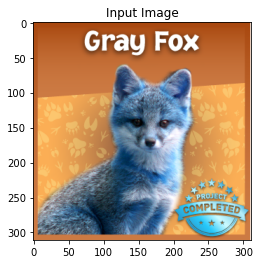

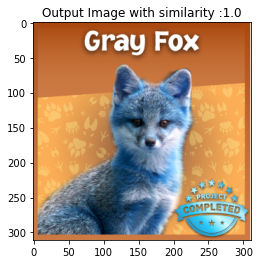

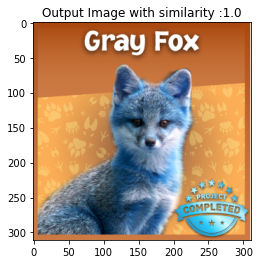

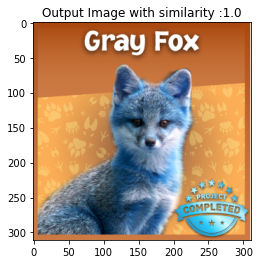

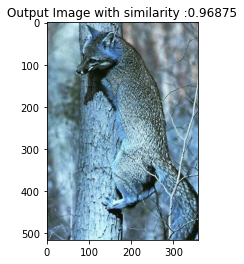

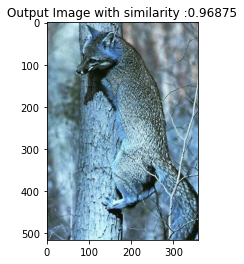

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

f, axarr = plt.subplots(1,1)
axarr.imshow(fruit_images[0])
axarr.set_title('Input Image')

f1, axarr1 = plt.subplots(1,1)
axarr1.imshow(fruit_images[retrieve_similar_images_positions[4]])
axarr1.set_title('Output Image with similarity :' + str(hist_intersection[retrieve_similar_images_positions[4]]))
f2, axarr2 = plt.subplots(1,1)
axarr2.imshow(fruit_images[retrieve_similar_images_positions[3]])
axarr2.set_title('Output Image with similarity :' + str(hist_intersection[retrieve_similar_images_positions[3]]))
f3, axarr3 = plt.subplots(1,1)
axarr3.imshow(fruit_images[retrieve_similar_images_positions[2]])
axarr3.set_title('Output Image with similarity :' + str(hist_intersection[retrieve_similar_images_positions[2]]))
f4, axarr4 = plt.subplots(1,1)
axarr4.imshow(fruit_images[retrieve_similar_images_positions[1]])
axarr4.set_title('Output Image with similarity :' + str(hist_intersection[retrieve_similar_images_positions[1]]))
f5, axarr5 = plt.subplots(1,1)
axarr5.imshow(fruit_images[retrieve_similar_images_positions[0]])
axarr5.set_title('Output Image with similarity :' + str(hist_intersection[retrieve_similar_images_positions[0]]))

In [ ]:
retrieve_similar_images_positions

[6, 0, 7, 9]

In [ ]:
hist_intersection

[1.0,
 0.96875,
 0.7301587301587301,
 0.8771929824561403,
 0.6716417910447762,
 0.7301587301587301,
 0.96875,
 1.0,
 0.6612903225806451,
 1.0]